In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/berkeley/berkeley.csv"

X = pd.read_csv(urlfile)
num_features = X._get_numeric_data().columns.to_list()

X['accepted'] = np.where((X['accepted'] == ' Yes') , 1, 0)
df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()

df.head()

,gender,department,accepted
0,Male,A,1
1,Male,A,1
2,Male,A,1
3,Male,A,1
4,Male,A,1


## Model training and test

In [3]:
X = df.drop('accepted', axis=1)
y = df['accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='accepted')
model.predict(X_test.iloc[:100, :])

CPU times: total: 0 ns
Wall time: 13.4 ms


array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       802
           1       0.67      0.57      0.62       526

    accuracy                           0.72      1328
   macro avg       0.71      0.69      0.70      1328
weighted avg       0.72      0.72      0.72      1328



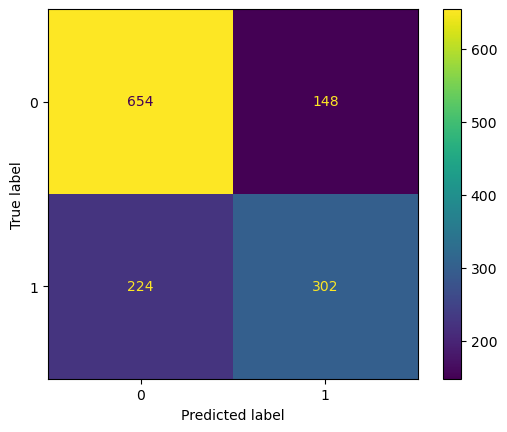

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='gender',
    missing_subgroup_val="Unknown"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 91.31it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]

Computing correctenesses for all valid if-thens.



100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 270.19it/s]

Number of if-thens: 8


In [8]:
# ### Uncomment if you wish to load rules object from disk

# import dill

# with open("rulesAdultFairTest.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [9]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesBerkeley.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If department =  C:
	Subgroup 'Female', 31.89% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 28.92% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
If department =  E:
	Subgroup 'Female', 25.39% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 15.95% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
If department =  D:
	Subgroup 'Female', 21.65% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 31.35% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
If department =  F:
	Subgroup 'Female', 21.06% covered
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [11]:
feature_weights = {"gender": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [12]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If department =  C:
	Subgroup 'Female', 31.89% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Subgroup 'Male', 28.92% covered out of 2590
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	No bias!
If department =  E:
	Subgroup 'Female', 25.39% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Subgroup 'Male', 15.95% covered out of 2590
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	No bias!
If department =  D:
	Subgroup 'Female', 21.65% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
		Aggre

## Minimum cost above threshold

In [13]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

With the given parameters, no recourses showing unfairness have been found!



## Mean cost above threshold

In [14]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

With the given parameters, no recourses showing unfairness have been found!



## Number above threshold

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

With the given parameters, no recourses showing unfairness have been found!



# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [18]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If department =  C:
	Subgroup 'Female', 31.89% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 28.92% covered out of 2590
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	No bias!
	Cumulative correctness plot for the above recourses:


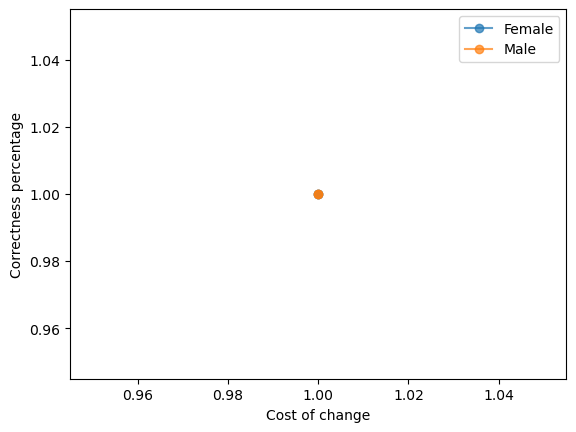

If department =  E:
	Subgroup 'Female', 25.39% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 15.95% covered out of 2590
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	No bias!
	Cumulative correctness plot for the above recourses:


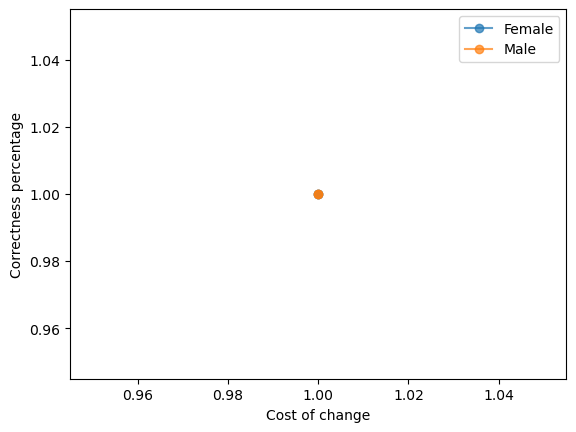

If department =  D:
	Subgroup 'Female', 21.65% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 31.35% covered out of 2590
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	No bias!
	Cumulative correctness plot for the above recourses:


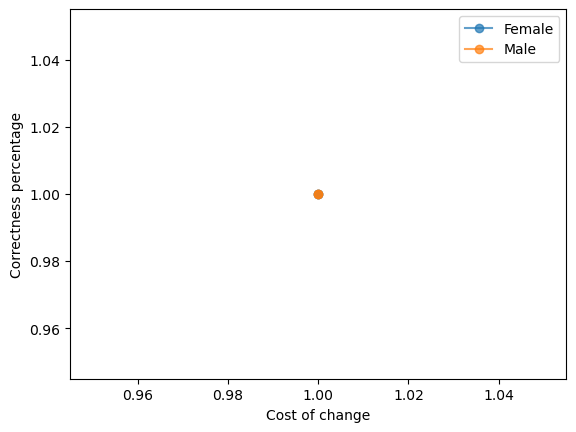

If department =  F:
	Subgroup 'Female', 21.06% covered out of 1835
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	Subgroup 'Male', 23.78% covered out of 2590
		Make department =  A with correctness 100.00%.
		Make department =  B with correctness 100.00%.
	No bias!
	Cumulative correctness plot for the above recourses:


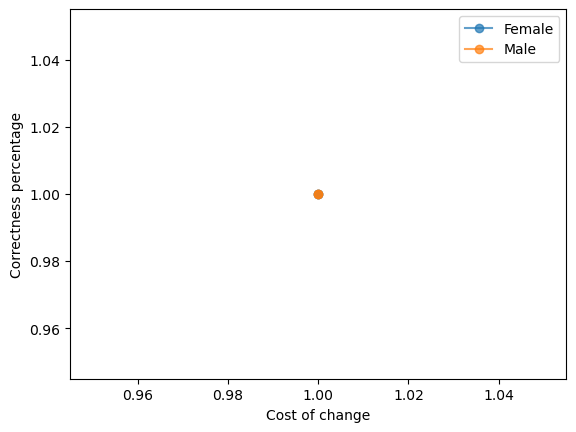

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="gender")

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [17]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)